In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Parameter setup

In [1]:
#### basic dimensions and state space grid:

N_P = 2 # price grid dimension - 1 (because we start from 0)

N_Y = 1 # (inventory grid dimension - 1)/2 (because we allow both - and + and 0)

dim_X = 2*N_P-1

dim_Y = 2*N_Y+1

prices = list(range(N_P+1)) # all integer list [0,1,2,...,N_P]
prices = np.array(prices)

dim_action_a = N_P+2
dim_action_b = N_P+2
# the additional state (the last 1) for quoted price is for doing nothing

#### set (tick size, time grid, transition kernel)

tick = 1/3 # the quoted prices are in the set: (0*tick, 1*tick, 2*tick, ..., N_P*tick)

Delta = 0.1 # the actions are done in the grid: 0*Delta, 1*Delta, 2*Delta, ......

k1 = 2 # 2/(tick*M), where M is an integer specifying the optimal spread, as multiple of (tick/2)

p0 = 0.4

A = np.exp(1)*(1/Delta)*p0

def lambda_e(D): # if the distance between the quoted price and the mid-price is D>0, then the probability that this order is executed is lambda_e(D)*Delta.
    return np.exp(-k1*D)*A

#### discount factor for the infinite horizon value function

GAMMA = 0.95
GAMMA_Delta = np.exp(-GAMMA*Delta)

print(GAMMA_Delta)

#### transition prob matrix of state variable X_i , where X_i is the mid-price

Q_X_i_i1 = np.zeros((dim_X-1,dim_X))
Q_X_i1_i = np.zeros((dim_X-1,dim_X))

lambda_i_i1 = (1/Delta)*np.array([0.5,1/3]) #3.5*np.ones(dim_X-1)
lambda_i1_i = (1/Delta)*np.array([1/3,0.5]) #3.5*np.ones(dim_X-1)

for i in range(dim_X-1):
  Q_X_i1_i[i,i] = lambda_i1_i[i]
  Q_X_i1_i[i,i+1] = -lambda_i1_i[i]
  Q_X_i_i1[i,i] = -lambda_i_i1[i]
  Q_X_i_i1[i,i+1] = lambda_i_i1[i]

Q_X = np.zeros((dim_X,dim_X))
Q_X[0:(dim_X-1), 0:dim_X] = Q_X[0:(dim_X-1), 0:dim_X] + Q_X_i_i1
Q_X[1:dim_X, 0:dim_X] = Q_X[1:dim_X, 0:dim_X] + Q_X_i1_i

P_X = np.identity(dim_X) + Delta*Q_X # X_i is a finite-state Markov jump process, and the transition probability matrix of X_i is P_X.
print(P_X)

0.9093729344682314
[[0.5        0.5        0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.         0.5        0.5       ]]


# do the DPP Bellman equation iteration

In [6]:
N_iteration = 100
V_star = np.zeros( (dim_X, dim_Y) ) # the optimal value function
V_star_records = np.zeros( (dim_X, dim_Y, N_iteration+1) )

In [7]:

for i in range(N_iteration):
  V_star = V_star_records[ : , : , i]
  # loop for every state:
  for idx_x in range(dim_X):
    for idx_y in range(dim_Y):
        # update the value function at the state variable (idx_x,idx_y)
        # Part 1: Make a list of the actions available from the current state, given the state at i-th time point
        # idx_x = X_data[i] # all are integers, i.e., 0,1,2,...,dim_X-1
        # idx_y = Y_data[i] # all are integers, i.e., 0,1,2,...,dim_Y-1
        x = idx_x + 1 # midprice=x*tick_size/2 and x is in (1,2,...,dim_X)
        y = idx_y - N_Y # y = the true signed integer value of inventory
        V_max = - float('inf') # record the maximum value
        if y == -N_Y: # then sell order is not allowed
            action_a_list = [dim_action_a-1] # do nothing for ask order
            action_b_list = prices[prices<x/2] # the action is exactly equal to the index
            for p_b in action_b_list:
                # transition prob weight vector of X
                vec_prob_X = P_X[ idx_x, ]
                # transition prob weight vector of Y
                vec_prob_Y = np.zeros( dim_Y )
                p_buy_fill = lambda_e( x*tick/2-p_b*tick )*Delta
                vec_prob_Y[idx_y] = 1 - p_buy_fill
                vec_prob_Y[idx_y+1] = p_buy_fill
                # do the Bellman equation iteration
                V_tmp = p_buy_fill * (x*tick/2-p_b*tick) + GAMMA_Delta * np.dot(vec_prob_X.T ,np.dot(V_star, vec_prob_Y)) # the np.dot is doing the expectation
                if V_tmp>V_max:
                    V_max=V_tmp

        elif y == N_Y: # then buy order is not allowed
            action_a_list = prices[prices>x/2]
            action_b_list = [dim_action_b-1] # do nothing for buy order
            for p_a in action_a_list:
                # transition prob weight vector of X
                vec_prob_X = P_X[ idx_x, ]
                # transition prob weight vector of Y
                vec_prob_Y = np.zeros( dim_Y )
                p_ask_fill = lambda_e( -x*tick/2+p_a*tick )*Delta
                vec_prob_Y[idx_y] = 1 - p_ask_fill
                vec_prob_Y[idx_y-1] = p_ask_fill # here is -1 for inventory value change !!!!!!
                # do the Bellman equation iteration
                V_tmp = p_ask_fill * (-x*tick/2+p_a*tick) + GAMMA_Delta * np.dot(vec_prob_X.T ,np.dot(V_star, vec_prob_Y)) # the np.dot is doing the expectation
                if V_tmp>V_max:
                    V_max=V_tmp

        else: # then both sell and buy orders are allowed
            action_a_list = prices[prices>x/2] # the action is exactly equal to the index
            action_b_list = prices[prices<x/2] # the action is exactly equal to the index
            for p_a in action_a_list:
                for p_b in action_b_list:
                    # transition prob weight vector of X
                    vec_prob_X = P_X[ idx_x, ]
                    # transition prob weight vector of Y

                    vec_prob_Y = np.zeros( dim_Y )
                    p_ask_fill = lambda_e( -x*tick/2+p_a*tick )*Delta
                    p_buy_fill = lambda_e( x*tick/2-p_b*tick )*Delta

                    vec_prob_Y[idx_y+1] = ( 1 - p_ask_fill )*p_buy_fill
                    vec_prob_Y[idx_y] = ( 1 - p_ask_fill )*( 1 - p_buy_fill ) + p_ask_fill * p_buy_fill
                    vec_prob_Y[idx_y-1] = ( 1 - p_buy_fill )*p_ask_fill
                    # do the Bellman equation iteration
                    V_tmp = p_ask_fill * (-x*tick/2+p_a*tick) + p_buy_fill * (x*tick/2-p_b*tick) + GAMMA_Delta * np.dot(vec_prob_X.T ,np.dot(V_star, vec_prob_Y)) # the np.dot is doing the expectation
                    if V_tmp > V_max:
                        V_max = V_tmp

        # the maximum value update
        #V_star[ idx_x, idx_y ] = V_max # we should not do this, because we should keep V_star unchanged in the right hand side of Bellman equation
        V_star_records[ idx_x, idx_y, i+1 ] = V_max


In [ ]:
#np.save('/content/V500.npy' , V_star_records)

## Converge check: evolution of value function v.s. iteration steps

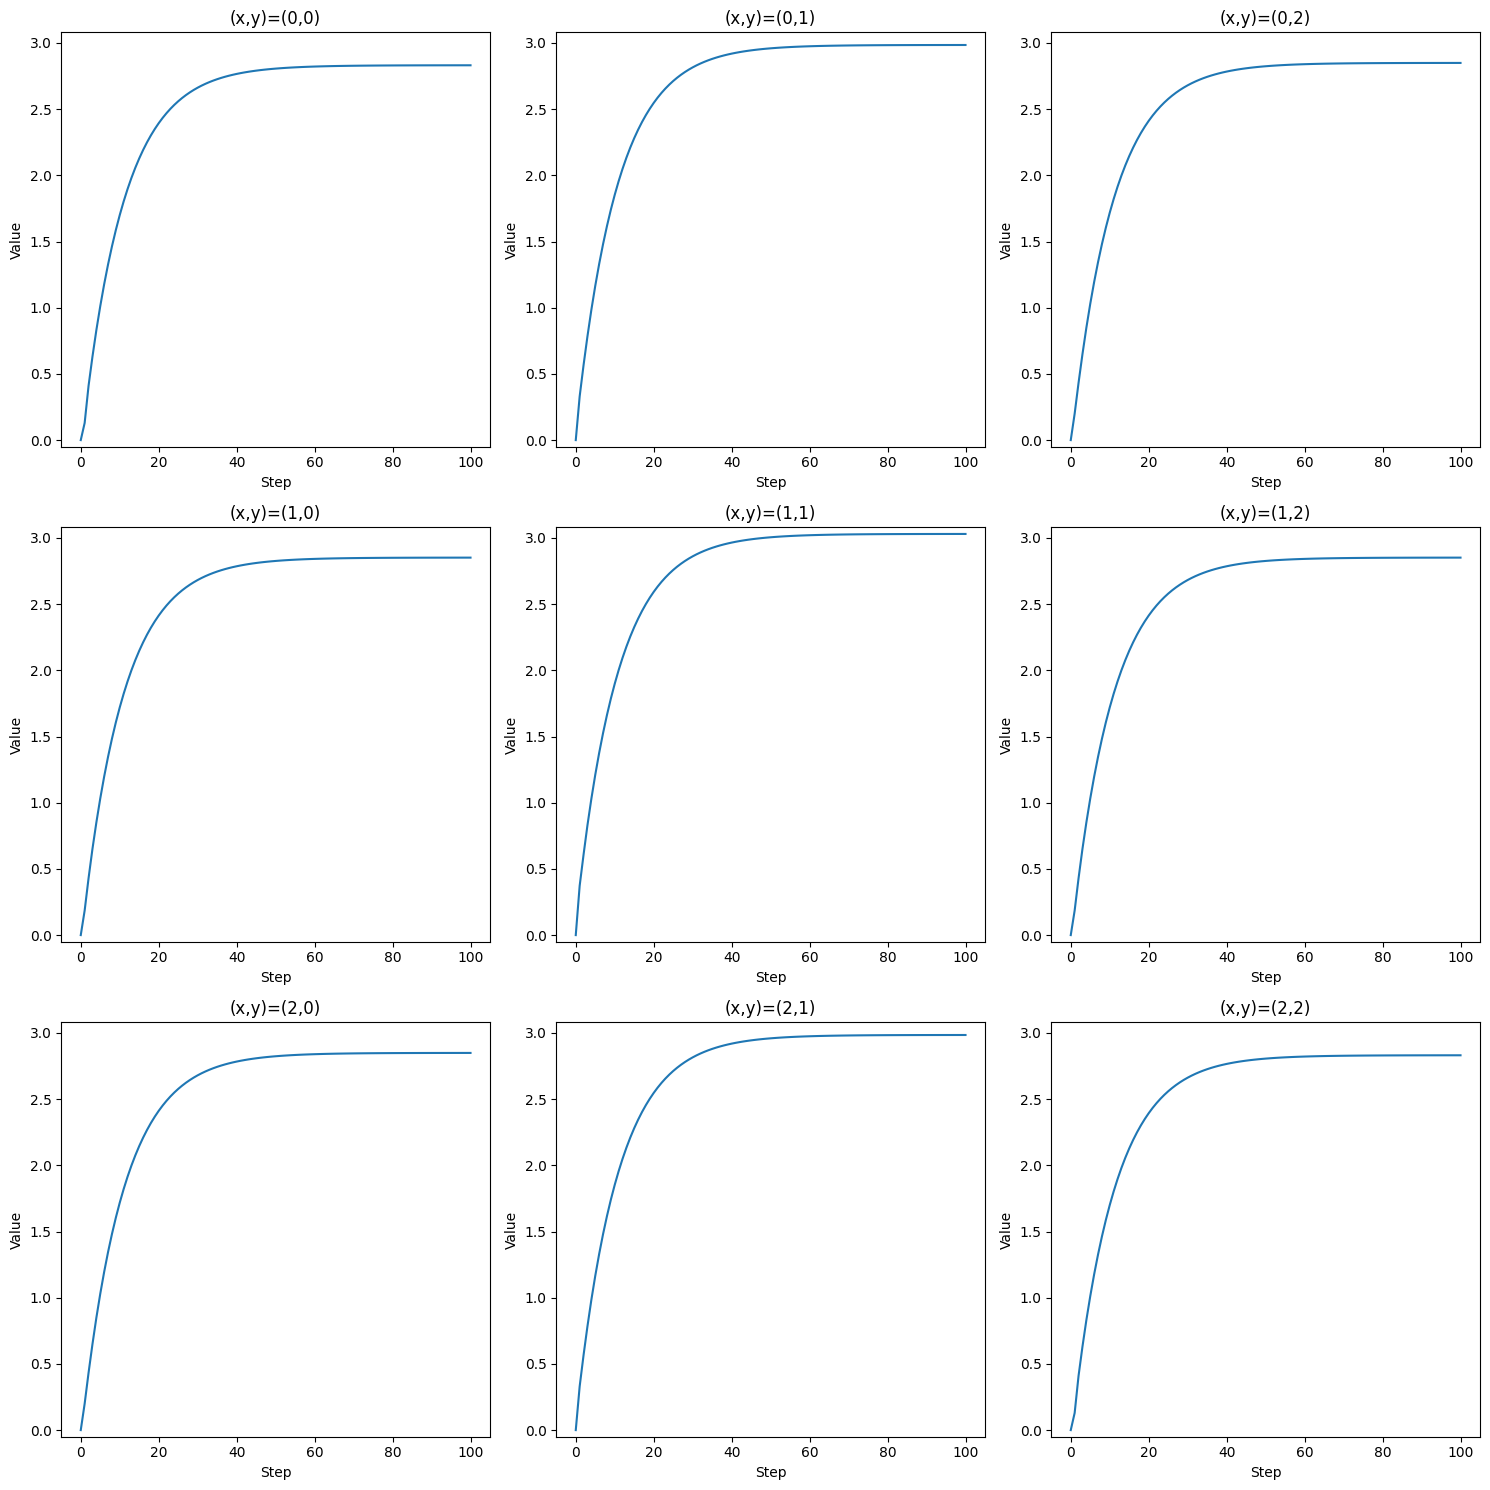

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# # Load the array from the provided file
# V_star_records = np.load('/mnt/data/V500.npy')

# # Check if the shape matches the expected shape
# expected_shape = (3, 3, 500)
# if V_star_records.shape != expected_shape:
#     raise ValueError(f"The loaded array shape {V_star_records.shape} doesn't match the expected shape {expected_shape}.")

# Create a grid of plots
fig, axs = plt.subplots(dim_X, dim_Y, figsize=(15, 15))

global_min = np.min(V_star_records)
global_max = np.max(V_star_records)

for i in range(dim_X):
    for j in range(dim_Y):
        axs[i, j].plot(V_star_records[i, j, :])
        axs[i, j].set_title(f"(x,y)=({i},{j})")
        axs[i, j].set_xlabel("Step")
        axs[i, j].set_ylabel("Value")
        axs[i, j].set_ylim(global_min-0.05, global_max+0.05)

plt.tight_layout()
plt.show()


In [9]:
V_star_records[:, :, N_iteration]

array([[2.83100481, 2.98422371, 2.84877618],
       [2.85107286, 3.02986276, 2.85107286],
       [2.84877618, 2.98422371, 2.83100481]])

In [10]:
V_star

array([[2.83098299, 2.98420188, 2.84875435],
       [2.85105103, 3.02984094, 2.85105103],
       [2.84875435, 2.98420188, 2.83098299]])

# find the optimal policy using V_star

In [12]:
p_a_star = np.zeros( (dim_X, dim_Y) )
p_b_star = np.zeros( (dim_X, dim_Y) )

In [13]:
for idx_x in range(dim_X):
  for idx_y in range(dim_Y):
    # update the value function at the state variable (idx_x,idx_y)
    # Part 1: Make a list of the actions available from the current state, given the state at i-th time point
    # idx_x = X_data[i] # all are integers, i.e., 0,1,2,...,dim_X-1
    # idx_y = Y_data[i] # all are integers, i.e., 0,1,2,...,dim_Y-1
    x = idx_x + 1 # midprice=x*tick_size/2 and x is in (1,2,...,dim_X)
    y = idx_y - N_Y # y = the true signed integer value of inventory
    V_max = - float('inf') # record the maximum value
    if y == -N_Y: # then sell order is not allowed

        action_a_list = [dim_action_a-1] # do nothing for ask order
        p_a_star[idx_x, idx_y] = dim_action_a-1
        action_b_list = prices[prices<x/2] # the action is exactly equal to the index
        for p_b in action_b_list:
            # transition prob weight vector of X
            vec_prob_X = P_X[ idx_x, ]
            # transition prob weight vector of Y
            vec_prob_Y = np.zeros( dim_Y )
            p_buy_fill = lambda_e( x*tick/2-p_b*tick )*Delta
            vec_prob_Y[idx_y] = 1 - p_buy_fill
            vec_prob_Y[idx_y+1] = p_buy_fill
            # do the Bellman equation iteration
            V_tmp = p_buy_fill * (x*tick/2-p_b*tick) + GAMMA_Delta * np.dot(vec_prob_X.T ,np.dot(V_star, vec_prob_Y))
            if V_tmp>V_max:
                V_max=V_tmp
                p_b_star[idx_x, idx_y] = p_b

    elif y == N_Y: # then buy order is not allowed
        action_a_list = prices[prices>x/2]
        action_b_list = [dim_action_b-1] # do nothing for buy order
        p_b_star[idx_x, idx_y] = dim_action_b-1
        for p_a in action_a_list:
            # transition prob weight vector of X
            vec_prob_X = P_X[ idx_x, ]
            # transition prob weight vector of Y
            vec_prob_Y = np.zeros( dim_Y )
            p_ask_fill = lambda_e( -x*tick/2+p_a*tick )*Delta
            vec_prob_Y[idx_y] = 1 - p_ask_fill
            vec_prob_Y[idx_y-1] = p_ask_fill # here is -1 for inventory value change !!!!!!
            # do the Bellman equation iteration
            V_tmp = p_ask_fill * (-x*tick/2+p_a*tick) + GAMMA_Delta * np.dot(vec_prob_X.T ,np.dot(V_star, vec_prob_Y))
            if V_tmp>V_max:
                V_max=V_tmp
                p_a_star[idx_x, idx_y] = p_a

    else: # then both sell and buy orders are allowed
        action_a_list = prices[prices>x/2] # the action is exactly equal to the index
        action_b_list = prices[prices<x/2] # the action is exactly equal to the index
        for p_a in action_a_list:
            for p_b in action_b_list:
                # transition prob weight vector of X
                vec_prob_X = P_X[ idx_x, ]
                # transition prob weight vector of Y

                vec_prob_Y = np.zeros( dim_Y )
                p_ask_fill = lambda_e( -x*tick/2+p_a*tick )*Delta
                p_buy_fill = lambda_e( x*tick/2-p_b*tick )*Delta
        #############  !!!!!!! to determine this prob !!!!!!
                vec_prob_Y[idx_y+1] = ( 1 - p_ask_fill )*p_buy_fill
                vec_prob_Y[idx_y] = ( 1 - p_ask_fill )*( 1 - p_buy_fill ) + p_ask_fill * p_buy_fill
                vec_prob_Y[idx_y-1] = ( 1 - p_buy_fill )*p_ask_fill
                # do the Bellman equation iteration
                V_tmp = p_ask_fill * (-x*tick/2+p_a*tick) + p_buy_fill * (x*tick/2-p_b*tick) + GAMMA_Delta * np.dot(vec_prob_X.T ,np.dot(V_star, vec_prob_Y))
                if V_tmp > V_max:
                    V_max = V_tmp
                    p_a_star[idx_x, idx_y] = p_a
                    p_b_star[idx_x, idx_y] = p_b

the policy below is correct: column 0 is Y=0

In [14]:
p_a_star

array([[3., 2., 2.],
       [3., 2., 2.],
       [3., 2., 2.]])

In [15]:
p_b_star

array([[0., 0., 3.],
       [0., 0., 3.],
       [0., 0., 3.]])